Leer Texto de imagenes

In [20]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import csv
import matplotlib.pyplot as plt
import cv2
import os
import torch

Usando dispositivo: cpu


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


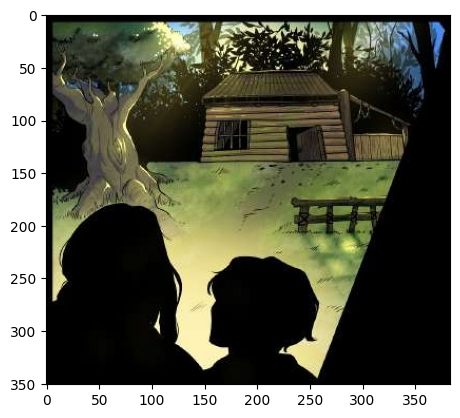

Resultado total de EasyOCR: 
Resultado total de TrOCR: 
Resultado de TrOCR guardado en: ..\..\data\output\output_text_test\Chapter01\page1_img\panel_1.txt


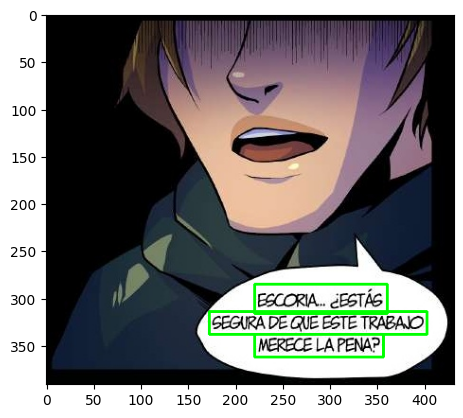

Resultado total de EasyOCR: ESCCRIA cESTÁS SECURA DEQUE ESTE TRABAJO MERECE LAPENA?
Resultado total de TrOCR: ESCORIA... ¿ESTAS SEGURA DE QUE ESE TRABACO MELECE LA PENAP. PES?
Resultado de TrOCR guardado en: ..\..\data\output\output_text_test\Chapter01\page1_img\panel_2.txt


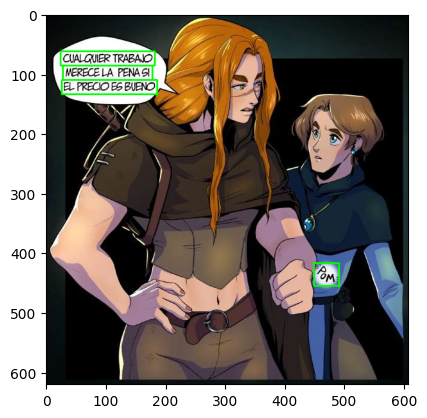

Resultado total de EasyOCR: CUALQUIER TRABAI MEreCeLA peNASI EL PRECIOESBUENO FBM
Resultado total de TrOCR: CUAL QUIER TRABACIO MERECE LA PENA SI EL PRICIO ES BUSNO ¿OM
Resultado de TrOCR guardado en: ..\..\data\output\output_text_test\Chapter01\page1_img\panel_3.txt


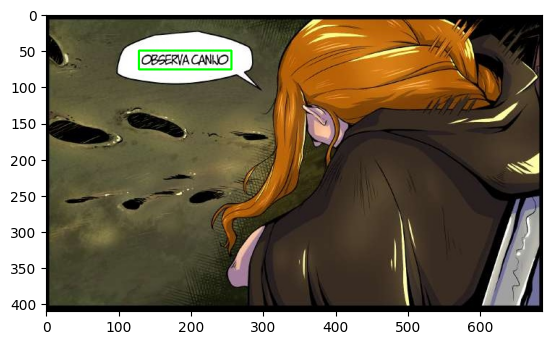

Resultado total de EasyOCR: OBSERVACANNO
Resultado total de TrOCR: OESRIA CANNO
Resultado de TrOCR guardado en: ..\..\data\output\output_text_test\Chapter01\page1_img\panel_4.txt


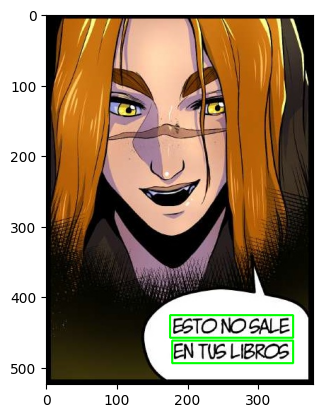

Resultado total de EasyOCR: ESTONOSALE EN TUSLIBROS
Resultado total de TrOCR: ESTO NO SALE TUS LIBROS
Resultado de TrOCR guardado en: ..\..\data\output\output_text_test\Chapter01\page1_img\panel_5.txt


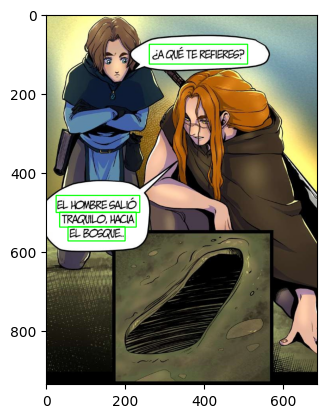

Resultado total de EasyOCR: CAQUÉ TE REFIERES? EL HOMBRE SALIÓ TRAQUILO; HACIA ELBOQUE
Resultado total de TrOCR: ¿A QUE TE REFIERES? EL HOMBRE SALIÓ TRACULO, HACIA EL BOS QUE...
Resultado de TrOCR guardado en: ..\..\data\output\output_text_test\Chapter01\page2_img\panel_1.txt


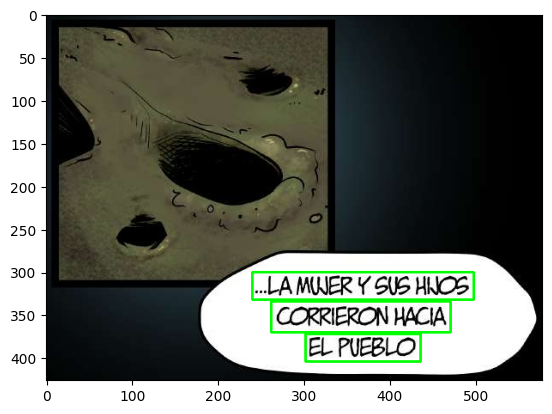

Resultado total de EasyOCR: ~LAMUERY SUS HKOS CORRIERON HACIA EL PUEBLO
Resultado total de TrOCR: LA MUER Y SUS HACOS CORIERON HACIA EL PUEBLO
Resultado de TrOCR guardado en: ..\..\data\output\output_text_test\Chapter01\page2_img\panel_2.txt


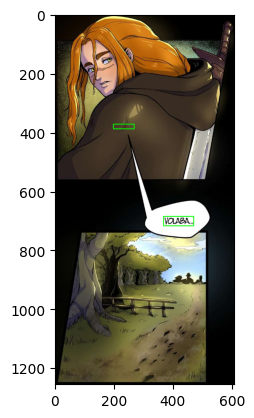

TypeError: slice indices must be integers or None or have an __index__ method

In [25]:
# Verificar si CUDA está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Inicializar el procesador y el modelo de TrOCR
processor = TrOCRProcessor.from_pretrained(r'..\..\train\models\procesador_finetuneado_trOCR')
model = VisionEncoderDecoderModel.from_pretrained(r'..\..\train\models\modelo_finetuneado_trOCR').to(device)

# Inicializar el lector de EasyOCR (no necesita CUDA)
reader = easyocr.Reader(['es'])  # Puedes agregar otros idiomas si es necesario

# Directorios de entrada y salida
input_dir = r'..\..\data\output\divide_images_test'
output_dir = r'..\..\data\output\output_text_test'

# Función para recortar una región de la imagen
def crop_image(image, bbox):
    top_left, top_right, bottom_right, bottom_left = bbox
    x_min = min(int(top_left[0]), int(bottom_left[0]))
    x_max = max(int(top_right[0]), int(bottom_right[0]))
    y_min = min(int(top_left[1]), int(top_right[1]))
    y_max = max(int(bottom_left[1]), int(bottom_right[1]))
    return image[y_min:y_max, x_min:x_max]

# Función para procesar una imagen
def process_image(image_path, output_file_path):
    # Cargar la imagen
    image = cv2.imread(image_path)

    # Detectar texto en la imagen
    result = reader.readtext(image)

    # Mostrar las áreas detectadas
    for (bbox, text, prob) in result:
        # Extraer las coordenadas del bounding box
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        top_right = tuple(map(int, top_right))
        bottom_right = tuple(map(int, bottom_right))
        bottom_left = tuple(map(int, bottom_left))

        # Dibujar el bounding box en la imagen
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

    # Mostrar la imagen con los bounding boxes
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    # Variables para almacenar los textos concatenados
    easyocr_text_total = ""
    tocr_text_total = ""

    # Procesar cada región detectada con TrOCR
    for (bbox, text, prob) in result:
        cropped_image = crop_image(image, bbox)
        pil_image = Image.fromarray(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

        # Preprocesar la imagen
        pixel_values = processor(pil_image, return_tensors="pt").pixel_values.to(device)

        # Realizar el reconocimiento de texto
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        # Concatenar los resultados
        easyocr_text_total += text + " "
        tocr_text_total += generated_text + " "

    # Mostrar los resultados concatenados
    print(f'Resultado total de EasyOCR: {easyocr_text_total.strip()}')
    print(f'Resultado total de TrOCR: {tocr_text_total.strip()}')

    # Guardar el resultado de TrOCR en el archivo de texto
    with open(output_file_path, "w", encoding="utf-8") as text_file:
        text_file.write(tocr_text_total.strip())

    print(f'Resultado de TrOCR guardado en: {output_file_path}')

# Recorrer recursivamente el directorio de entrada
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Obtener la ruta completa de la imagen
            image_path = os.path.join(root, file)

            # Crear la ruta de salida correspondiente
            relative_path = os.path.relpath(root, input_dir)
            output_dir_path = os.path.join(output_dir, relative_path)
            os.makedirs(output_dir_path, exist_ok=True)

            # Crear el nombre del archivo de texto de salida
            output_file_path = os.path.join(output_dir_path, os.path.splitext(file)[0] + ".txt")

            # Procesar la imagen
            process_image(image_path, output_file_path)